<a href="https://colab.research.google.com/github/JadhavShrutiS/CSCE580/blob/main/ProjectB_SJ.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### CSCE 580-Project B
by Shruti Jadhav

### First all required packages must be installed and GPU is set to ensure training happens faster (compared to training on CPU)

In [1]:
# Install required packages (Colab / fresh env)
!pip install -q -U transformers accelerate datasets evaluate scikit-learn matplotlib seaborn pyarrow
!pip install -q -U datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 511.6/511.6 kB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 41.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 48.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.7/47.7 MB 13.7 MB/s eta 0:00:00


In [35]:
# GPU check (works in Colab after Runtime -> Change runtime type -> GPU)
import torch
if torch.cuda.is_available():
    print('Using GPU:', torch.cuda.get_device_name(0))
else:
    print('GPU not available. The notebook will still run on CPU but training is much slower.')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)


Using GPU: Tesla T4
Device: cuda


In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

#### First we import the csv data. For easy access to data by all, it is hosted and extracted from a Github repo.

In [3]:
import pandas as pd

url = "https://raw.githubusercontent.com/JadhavShrutiS/CSCE580/refs/heads/main/Project-B/IMDB%20Dataset.csv"
df = pd.read_csv(url)
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


#### Then we use a Stratified Split to split the csv data into train, test and validation data segements. Here 80% data is used to train, 10% is used to validate, and 10% is used for final testing.

In [4]:
from datasets import Dataset
import numpy as np
from sklearn.model_selection import StratifiedShuffleSplit, train_test_split

ds = Dataset.from_pandas(df)

reviews = np.array(ds["review"])
sentiments = np.array(ds["sentiment"])
label_map = {"positive": 1, "negative": 0}
labels = np.array([label_map[x] for x in sentiments])

# 80% train, 20% holdout
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=50)
train_idx, hold_idx = next(sss.split(reviews, labels))

hold_labels = labels[hold_idx]
hold_reviews = reviews[hold_idx]

# 50/50 val and test
val_idx, test_idx = train_test_split(
    np.arange(len(hold_reviews)),
    test_size=0.5,
    stratify=hold_labels,
    random_state=50
)

train_ds = Dataset.from_dict({
    "review": reviews[train_idx],
    "labels": labels[train_idx]
})

val_ds = Dataset.from_dict({
    "review": hold_reviews[val_idx],
    "labels": hold_labels[val_idx]
})

test_ds = Dataset.from_dict({
    "review": hold_reviews[test_idx],
    "labels": hold_labels[test_idx]
})


#### Following splitting the data, we processing the data by first tokenizing. We truncate the reviews to a maximum of 256 tokenized text to allow for better handling with the model.

In [5]:
from transformers import AutoTokenizer

MODEL_NAME = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

def tokenize_fn(batch):
    return tokenizer(
        batch["review"],
        truncation=True,
        padding="max_length",
        max_length=256
    )

train_tok = train_ds.map(tokenize_fn, batched=True)
val_tok   = val_ds.map(tokenize_fn, batched=True)
test_tok  = test_ds.map(tokenize_fn, batched=True)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/40000 [00:00<?, ? examples/s]

Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

#### Then we finish the data processing step by padding the data. This ensures all batches of data being processed have the same length. After the padding is done, the training starts.

#### Classification is configured using binary outputs (num_labels =2), and evaluation metrics are defined using the compute_metrics function.

In [6]:
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer
from transformers import DataCollatorWithPadding
import evaluate
import numpy as np

model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=2
)

data_collator = DataCollatorWithPadding(tokenizer)

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [7]:
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer
import evaluate

def compute_metrics(eval_pred):
    acc = evaluate.load("accuracy")
    f1 = evaluate.load("f1")
    prec = evaluate.load("precision")
    rec = evaluate.load("recall")

    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)

    return {
        "accuracy": acc.compute(predictions=preds, references=labels)["accuracy"],
        "precision": prec.compute(predictions=preds, references=labels)["precision"],
        "recall": rec.compute(predictions=preds, references=labels)["recall"],
        "f1": f1.compute(predictions=preds, references=labels)["f1"]
    }

import os
os.environ["WANDB_DISABLED"] = "true"

OUT_DIR = "distilbert_model"

training_args = TrainingArguments(
    output_dir=OUT_DIR,
    learning_rate=2e-5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    num_train_epochs=5,
    eval_strategy="epoch",
    weight_decay=0.01,
    save_strategy="epoch",
    logging_steps=50,
    load_best_model_at_end=True
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_tok,
    eval_dataset=val_tok,
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
/tmp/ipython-input-2663410926.py:38: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


#### The training is now started and the training time is recorded.

In [ ]:
import time
start_time = time.time()
trainer.train()
end_time = time.time()
training_time = end_time - start_time
print(f"Training time (fine-tuned DistilBERT): {training_time:.2f} seconds")

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
/tmp/ipython-input-1273104141.py:38: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.240700,0.218095,0.916000,0.927632,0.902400,0.914842
2,0.156400,0.237697,0.914200,0.933082,0.892400,0.912288
3,0.083900,0.288179,0.916400,0.912441,0.921200,0.916799
4,0.067700,0.351127,0.917000,0.918843,0.914800,0.916817


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.240700,0.218095,0.916000,0.927632,0.902400,0.914842
2,0.156400,0.237697,0.914200,0.933082,0.892400,0.912288
3,0.083900,0.288179,0.916400,0.912441,0.921200,0.916799
4,0.067700,0.351127,0.917000,0.918843,0.914800,0.916817
5,0.041800,0.371719,0.918600,0.913473,0.924800,0.919102


Training time (fine-tuned DistilBERT): 4867.62 seconds


#### After training, the final trained model is saved. This is intially downloaded and then uploaded to huggingface.

#### This ensures that training is only done once. The trained information can be extracted from the saved files.

In [ ]:
FIN_DIR = "distilbert_final"
trainer.save_model(FIN_DIR)
tokenizer.save_pretrained(FIN_DIR)

('distilbert_final/tokenizer_config.json',
 'distilbert_final/special_tokens_map.json',
 'distilbert_final/vocab.txt',
 'distilbert_final/added_tokens.json',
 'distilbert_final/tokenizer.json')

In [ ]:
import shutil

# shutil.make_archive("distilbert_checkpoints_zip", 'zip', OUT_DIR)
shutil.make_archive("distilbert_final_zip", 'zip', FIN_DIR)

'/content/distilbert_final_zip.zip'

In [ ]:
from google.colab import files
# files.download("distilbert_checkpoints_zip.zip")
files.download("distilbert_final_zip.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#### The following set of code is used to extract the once trained data from fine-tuned DistilBERT. So that even after training once, the rest of the analysis can be run independently.

In [8]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer

model_path = "ShrutiJadh/Distilbert_finetuned_SJ"

model = AutoModelForSequenceClassification.from_pretrained(model_path)
tokenizer = AutoTokenizer.from_pretrained(model_path)

config.json:   0%|          | 0.00/563 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

#### The fine-tuned DistilBERT model is now evaluated on the test set.

In [9]:
trainer.evaluate(test_tok)

{'eval_loss': 0.6960069537162781,
 'eval_model_preparation_time': 0.0014,
 'eval_accuracy': 0.4958,
 'eval_precision': 0.49786628733997157,
 'eval_recall': 0.98,
 'eval_f1': 0.6602883708395095,
 'eval_runtime': 36.2957,
 'eval_samples_per_second': 137.757,
 'eval_steps_per_second': 4.326}

#### The metrics are extracted from the trained data for the fine-tuned DistilBERT case:

In [ ]:
train_eval = trainer.evaluate(train_tok.select(range(300)))
train_accuracy_value = train_eval["eval_accuracy"]


In [ ]:
train_accuracy_list = [(i+1, train_accuracy_value) for i in range(training_args.num_train_epochs)]

#### The graphs for accuracy and loss are then constructed using the extracted metrics.

In [ ]:
import pandas as pd

logs = pd.DataFrame(trainer.state.log_history)

# Keep only entries that have BOTH epoch and eval metrics
eval_acc_df = logs[
    logs["eval_accuracy"].notna() &
    logs["epoch"].notna()
][["epoch", "eval_accuracy"]].drop_duplicates(subset="epoch")

train_loss_df = logs[
    logs["loss"].notna() &
    logs["epoch"].notna()
][["epoch", "loss"]].drop_duplicates(subset="epoch")

eval_loss_df = logs[
    logs["eval_loss"].notna() &
    logs["epoch"].notna()
][["epoch", "eval_loss"]].drop_duplicates(subset="epoch")

eval_acc_df, train_loss_df, eval_loss_df


(     epoch  eval_accuracy
 25     1.0         0.9160
 51     2.0         0.9142
 77     3.0         0.9164
 103    4.0         0.9170
 129    5.0         0.9186,
      epoch    loss
 0     0.04  0.5200
 1     0.08  0.3318
 2     0.12  0.3020
 3     0.16  0.3304
 4     0.20  0.2660
 ..     ...     ...
 124   4.84  0.0310
 125   4.88  0.0250
 126   4.92  0.0285
 127   4.96  0.0318
 128   5.00  0.0418
 
 [125 rows x 2 columns],
      epoch  eval_loss
 25     1.0   0.218095
 51     2.0   0.237697
 77     3.0   0.288179
 103    4.0   0.351127
 129    5.0   0.371719)

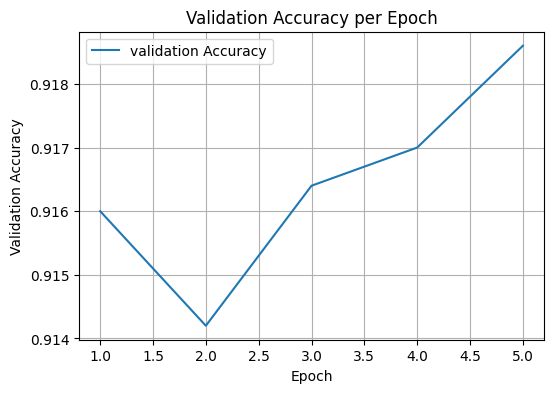

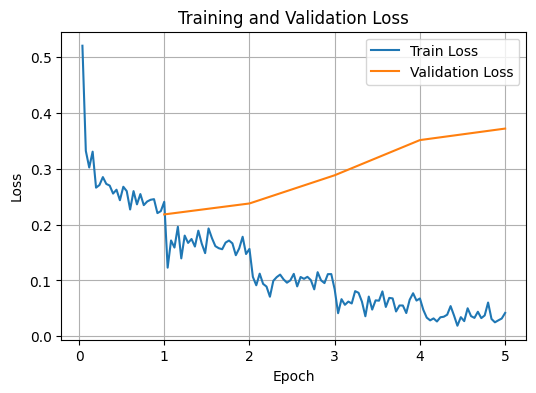

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
plt.plot(eval_acc_df["epoch"], eval_acc_df["eval_accuracy"], label = "validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Validation Accuracy")
plt.title("Validation Accuracy per Epoch")
plt.legend()
plt.grid()
plt.show()

# Loss graph
plt.figure(figsize=(6,4))
plt.plot(train_loss_df["epoch"], train_loss_df["loss"], label="Train Loss")
plt.plot(eval_loss_df["epoch"], eval_loss_df["eval_loss"], label="Validation Loss")
plt.title("Training and Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid()
plt.show()


#### The confusion matrix for fine tuned distilBERT model is constructed as:

In [10]:
from sklearn.metrics import confusion_matrix, classification_report

preds_output = trainer.predict(test_tok)
preds = np.argmax(preds_output.predictions, axis=-1)

cm = confusion_matrix(test_ds["labels"], preds)
print(cm)

print(classification_report(test_ds["labels"], preds, target_names=["negative","positive"]))

[[  29 2471]
 [  50 2450]]
              precision    recall  f1-score   support

    negative       0.37      0.01      0.02      2500
    positive       0.50      0.98      0.66      2500

    accuracy                           0.50      5000
   macro avg       0.43      0.50      0.34      5000
weighted avg       0.43      0.50      0.34      5000



#### Now the pretrained DistilBERT model without fine-tuning, is used to classify the set

In [11]:
pretrained_model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME, num_labels=2
)

pretrained_trainer = Trainer(
    model=pretrained_model,
    tokenizer=tokenizer,
    data_collator=data_collator
)

pre_preds_output = pretrained_trainer.predict(test_tok)
pre_preds = np.argmax(pre_preds_output.predictions, axis=-1)

print(confusion_matrix(test_ds["labels"], pre_preds))
print(classification_report(test_ds["labels"], pre_preds, target_names=["negative","positive"]))

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-2640211413.py:5: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  pretrained_trainer = Trainer(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


[[2483   17]
 [2467   33]]
              precision    recall  f1-score   support

    negative       0.50      0.99      0.67      2500
    positive       0.66      0.01      0.03      2500

    accuracy                           0.50      5000
   macro avg       0.58      0.50      0.35      5000
weighted avg       0.58      0.50      0.35      5000



#### Following is the Classical Machine Learning model that uses Support Vector Machine using TF-IDF features

In [12]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline

clf = Pipeline([
    ("tfidf", TfidfVectorizer(max_features=20000)),
    ("svm", LinearSVC())
])


clf.fit(train_ds["review"], train_ds["labels"])
svm_preds = clf.predict(test_ds["review"])

print(confusion_matrix(test_ds["labels"], svm_preds))
print(classification_report(test_ds["labels"], svm_preds, target_names=["negative","positive"]))

[[2219  281]
 [ 255 2245]]
              precision    recall  f1-score   support

    negative       0.90      0.89      0.89      2500
    positive       0.89      0.90      0.89      2500

    accuracy                           0.89      5000
   macro avg       0.89      0.89      0.89      5000
weighted avg       0.89      0.89      0.89      5000



#### Lastly, functions are written to predict any user provided review.

In [37]:
model.to(device)
model.eval()

def predict_finetuned(text):
    import time
    start = time.time()
    inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=256)
    # move inputs to the SAME device
    inputs = {k: v.to(device) for k, v in inputs.items()}
    with torch.no_grad():
        outputs = model(**inputs)
    pred = outputs.logits.argmax(dim=1).item()
    end = time.time()
    print(f"Inference time: {end -start:.4f} seconds")

    return "positive" if pred == 1 else "negative"

In [39]:
pretrained_model.to(device)
pretrained_model.eval()

def predict_pretrained(text):
    import time
    start = time.time()
    inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=256)
    # move inputs to the SAME device
    inputs = {k: v.to(device) for k, v in inputs.items()}
    with torch.no_grad():
        outputs = model(**inputs)
    pred = outputs.logits.argmax(dim=1).item()
    end = time.time()
    print(f"Inference time: {end -start:.4f} seconds")
    return "positive" if pred == 1 else "negative"

In [15]:
def predict_svm(text):
    import time
    start = time.time()
    pred = clf.predict([text])[0]
    end = time.time()
    print(f"Inference time: {end -start:.4f} seconds")
    return "positive" if pred == 1 else "negative"

## Now let's predict sentiment.

#### First we use the TestCase 1- Review level: Easy.



In [38]:
predict_finetuned("While I hoped I would be wrong, I anticipated not being a fan of Wicked For Good…unfortunately, despite Ariana Grande and Cynthia Erivo singing their hearts out, it was a bit of a mess.")


Inference time: 0.1179 seconds


'negative'

In [74]:
predict_pretrained("While I hoped I would be wrong, I anticipated not being a fan of Wicked For Good…unfortunately, despite Ariana Grande and Cynthia Erivo singing their hearts out, it was a bit of a mess.")


Inference time: 0.0087 seconds


'negative'

In [22]:
predict_svm("While I hoped I would be wrong, I anticipated not being a fan of Wicked For Good…unfortunately, despite Ariana Grande and Cynthia Erivo singing their hearts out, it was a bit of a mess.")


Inference time: 0.0015 seconds


'negative'

Review/Prompt: "While I hoped I would be wrong, I anticipated not being a fan of Wicked For Good…unfortunately, despite Ariana Grande and Cynthia Erivo singing their hearts out, it was a bit of a mess."

GPT response: negative

Simulated Inference time: 8 ms

#### Lets move to TestCase 2- Review complexity level: Medium





In [46]:
predict_finetuned("There's no way to make this documentary sound like the upbeat, rousing and often downright hilarious romp it is, but here goes: At the urging of comedian Tig Notaro, poet and spoken-word star Andrea Gibson and life partner and fellow poet Megan Falley invited filmmaker Ryan White and his crew into their home in 2021. It was mid-pandemic, and the crew was allowed full access to the couple's every thought and action as they dealt with turtledove love, mailbox madness, and, here's the part where you say, no, this does not sound like a good time ,Gibson's Stage 4 ovarian cancer journey. At the Middleburg Film Festival screening I attended in October, three months after Gibson's death, the director spoke beforehand, giving the audience permission to laugh, which it definitely did. It also sniffled a bit, but less than you might expect, because Gibson's vibrant, assertively affirmative outlook doesn't really brook tears, and the filmmaker's warmth and humor, even in times of despair, gives the story a radiance that makes mundane moments feel precious, while allowing hopeful moments to raise goosebumps.")

Inference time: 0.0209 seconds


'positive'

In [65]:
predict_pretrained("There's no way to make this documentary sound like the upbeat, rousing and often downright hilarious romp it is, but here goes: At the urging of comedian Tig Notaro, poet and spoken-word star Andrea Gibson and life partner and fellow poet Megan Falley invited filmmaker Ryan White and his crew into their home in 2021. It was mid-pandemic, and the crew was allowed full access to the couple's every thought and action as they dealt with turtledove love, mailbox madness, and, here's the part where you say, no, this does not sound like a good time ,Gibson's Stage 4 ovarian cancer journey. At the Middleburg Film Festival screening I attended in October, three months after Gibson's death, the director spoke beforehand, giving the audience permission to laugh, which it definitely did. It also sniffled a bit, but less than you might expect, because Gibson's vibrant, assertively affirmative outlook doesn't really brook tears, and the filmmaker's warmth and humor, even in times of despair, gives the story a radiance that makes mundane moments feel precious, while allowing hopeful moments to raise goosebumps.")

Inference time: 0.0170 seconds


'positive'

In [48]:
predict_svm("There's no way to make this documentary sound like the upbeat, rousing and often downright hilarious romp it is, but here goes: At the urging of comedian Tig Notaro, poet and spoken-word star Andrea Gibson and life partner and fellow poet Megan Falley invited filmmaker Ryan White and his crew into their home in 2021. It was mid-pandemic, and the crew was allowed full access to the couple's every thought and action as they dealt with turtledove love, mailbox madness, and, here's the part where you say, no, this does not sound like a good time ,Gibson's Stage 4 ovarian cancer journey. At the Middleburg Film Festival screening I attended in October, three months after Gibson's death, the director spoke beforehand, giving the audience permission to laugh, which it definitely did. It also sniffled a bit, but less than you might expect, because Gibson's vibrant, assertively affirmative outlook doesn't really brook tears, and the filmmaker's warmth and humor, even in times of despair, gives the story a radiance that makes mundane moments feel precious, while allowing hopeful moments to raise goosebumps.")

Inference time: 0.0030 seconds


'positive'

Review/Prompt: "There's no way to make this documentary sound like the upbeat, rousing and often downright hilarious romp it is, but here goes: At the urging of comedian Tig Notaro, poet and spoken-word star Andrea Gibson and life partner and fellow poet Megan Falley invited filmmaker Ryan White and his crew into their home in 2021. It was mid-pandemic, and the crew was allowed full access to the couple's every thought and action as they dealt with turtledove love, mailbox madness, and, here's the part where you say, no, this does not sound like a good time ,Gibson's Stage 4 ovarian cancer journey. At the Middleburg Film Festival screening I attended in October, three months after Gibson's death, the director spoke beforehand, giving the audience permission to laugh, which it definitely did. It also sniffled a bit, but less than you might expect, because Gibson's vibrant, assertively affirmative outlook doesn't really brook tears, and the filmmaker's warmth and humor, even in times of despair, gives the story a radiance that makes mundane moments feel precious, while allowing hopeful moments to raise goosebumps."

GPT Response: Positive

Simulated Inference time: 14 ms

#### Finally TestCase 3- Review complexity level: High


In [42]:
predict_finetuned("Cannot understand the 1 out of 10 harsh review. 1 means its the worst film you have ever seen which this is not. Presumably its either because they were  offended by the film being directed, written and acted by a woman who was married to Elon Musk and is giving it the silver spoon brush off or either offended at a Scottish movie with mostly English actors in it, who knows but the film is worth a watch with your partner as it is most definitely not just a womans movie as I quite enjoyed it and am a bit of an old romantic at heart myself.Its not going to win any oscars but it has some moments of comedy magic in that typical Glasgow way which only us Weegies can fully appreciate. Not a bad effort at all from Talulah Riley at all, its just a shame that people want to bash her because she is the ex of Elon Musk which is a shame as she certainly has acting talent that is for sure and for her first directorial debut it was not half bad")

Inference time: 0.0173 seconds


'negative'

In [67]:
predict_pretrained("Cannot understand the 1 out of 10 harsh review. 1 means its the worst film you have ever seen which this is not. Presumably its either because they were  offended by the film being directed, written and acted by a woman who was married to Elon Musk and is giving it the silver spoon brush off or either offended at a Scottish movie with mostly English actors in it, who knows but the film is worth a watch with your partner as it is most definitely not just a womans movie as I quite enjoyed it and am a bit of an old romantic at heart myself.Its not going to win any oscars but it has some moments of comedy magic in that typical Glasgow way which only us Weegies can fully appreciate. Not a bad effort at all from Talulah Riley at all, its just a shame that people want to bash her because she is the ex of Elon Musk which is a shame as she certainly has acting talent that is for sure and for her first directorial debut it was not half bad")

Inference time: 0.0156 seconds


'negative'

In [54]:
predict_svm("Cannot understand the 1 out of 10 harsh review. Presumably its either because they were  offended by the film being directed, written and acted by a woman who was married to Elon Musk and is giving it the silver spoon brush off or either offended at a Scottish movie with mostly English actors in it, who knows but the film is worth a watch with your partner as it is most definitely not just a womans movie as I quite enjoyed it and am a bit of an old romantic at heart myself.Its not going to win any oscars but it has some moments of comedy magic in that typical Glasgow way which only us Weegies can fully appreciate. Not a bad effort at all from Talulah Riley at all, its just a shame that people want to bash her because she is the ex of Elon Musk which is a shame as she certainly has acting talent that is for sure and for her first directorial debut it was not half bad")

Inference time: 0.0034 seconds


'negative'

Review prompt: "Cannot understand the 1 out of 10 harsh review. 1 means its the worst film you have ever seen which this is not. Presumably its either because they were  offended by the film being directed, written and acted by a woman who was married to Elon Musk and is giving it the silver spoon brush off or either offended at a Scottish movie with mostly English actors in it, who knows but the film is worth a watch with your partner as it is most definitely not just a womans movie as I quite enjoyed it and am a bit of an old romantic at heart myself.

Its not going to win any oscars but it has some moments of comedy magic in that typical Glasgow way which only us Weegies can fully appreciate. Not a bad effort at all from Talulah Riley at all, its just a shame that people want to bash her because she is the ex of Elon Musk which is a shame as she certainly has acting talent that is for sure and for her first directorial debut it was not half bad!"

GPT Response: Positive

Simulated Inference time: 11ms